# Sales Transaction Analysis (Annex 2)

## 1. Objectives
This notebook provides a comprehensive interactive analysis of sales transactions (`annex2.csv`).

**Key Goals:**
- **Data Engineering**: Deep cleaning (separating returns, checking timestamp validity) and exporting a clean dataset.
- **Interactive Trending**: Visualize revenue over time with zoomable charts.
- **Pattern Recognition**: Use heatmaps to identify peak sales hours and days.
- **Performance Ranking**: Interactive ranking of top-selling products.

In [14]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

## 2. Data Loading & Engineering
Parsing dates and calculated fields.

In [15]:
file_path = 'annex2.csv'
df = pd.read_csv(file_path)

# Feature Engineering
# Use format='mixed' to handle inconsistent timestamp formats (e.g. missing microseconds)
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='mixed')
df['Revenue'] = df['Quantity Sold (kilo)'] * df['Unit Selling Price (RMB/kg)']
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.day_name()

# Deep Cleaning
# 1. Handle Returns: Create separate dataframe for analysis, exclude returns from 'sales_df'
sales_df = df[df['Sale or Return'] == 'sale'].copy()
returns_df = df[df['Sale or Return'] == 'return'].copy()
print(f"Total Transactions: {len(df)}")
print(f"Valid Sales: {len(sales_df)}")
print(f"Returns: {len(returns_df)}")

# 2. Validation: Ensure Quantity and Price are positive for Sales
invalid_sales = sales_df[(sales_df['Quantity Sold (kilo)'] <= 0) | (sales_df['Unit Selling Price (RMB/kg)'] < 0)]
if not invalid_sales.empty:
    print(f"Warning: {len(invalid_sales)} sales entries have non-positive quantity or price. Dropping them.")
    sales_df = sales_df.drop(invalid_sales.index)

# 3. Outlier check (e.g. enormous quantities)
q99 = sales_df['Quantity Sold (kilo)'].quantile(0.999)
outliers = sales_df[sales_df['Quantity Sold (kilo)'] > q99]
print(f"Note: {len(outliers)} transactions found with quantity > {q99:.2f} kg (99.9th percentile) - keeping for now as large orders.")

# EXPORT CLEANED DATA
cleaned_file_path = 'annex2_cleaned.csv'
sales_df.to_csv(cleaned_file_path, index=False)
print(f"Cleaned sales data exported to {cleaned_file_path}")
sales_df.head()

Total Transactions: 878503
Valid Sales: 878042
Returns: 461
Note: 879 transactions found with quantity > 2.65 kg (99.9th percentile) - keeping for now as large orders.
Cleaned sales data exported to annex2_cleaned.csv


,Date,Time,Item Code,Quantity Sold (kilo),Unit Selling Price (RMB/kg),Sale or Return,Discount (Yes/No),Datetime,Revenue,Hour,DayOfWeek
0,2020-07-01,09:15:07.924,102900005117056,0.396,7.6,sale,No,2020-07-01 09:15:07.924,3.0096,9,Wednesday
1,2020-07-01,09:17:27.295,102900005115960,0.849,3.2,sale,No,2020-07-01 09:17:27.295,2.7168,9,Wednesday
2,2020-07-01,09:17:33.905,102900005117056,0.409,7.6,sale,No,2020-07-01 09:17:33.905,3.1084,9,Wednesday
3,2020-07-01,09:19:45.450,102900005115823,0.421,10.0,sale,No,2020-07-01 09:19:45.450,4.2100,9,Wednesday
4,2020-07-01,09:20:23.686,102900005115908,0.539,8.0,sale,No,2020-07-01 09:20:23.686,4.3120,9,Wednesday


## 3. Interactive Dashboards

### 3.1 Revenue Trend Dashboard
Use the range slider below to zoom into specific weeks or days to analyze anomalies.

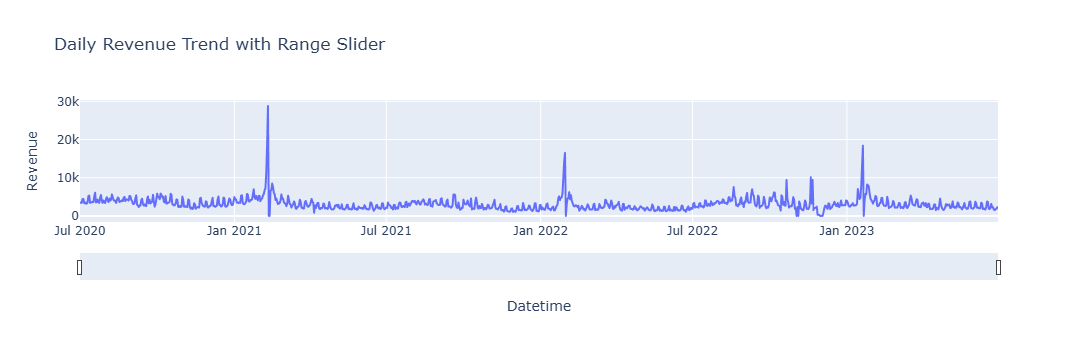

In [16]:
daily_sales = sales_df.set_index('Datetime').resample('D')['Revenue'].sum().reset_index()

fig = px.line(daily_sales, x='Datetime', y='Revenue', title='Daily Revenue Trend with Range Slider')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### 3.2 Intraday Sales Heatmap
This heatmap reveals the "Heartbeat" of the store. Darker colors indicate higher revenue intensity.

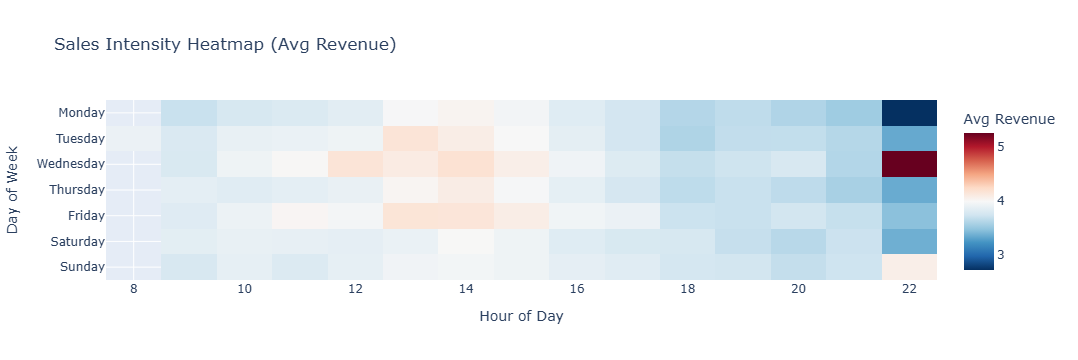

In [18]:
# pivot table for heatmap
heatmap_data = sales_df.pivot_table(index='DayOfWeek', columns='Hour', values='Revenue', aggfunc='mean')
# Reorder days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)

fig = px.imshow(heatmap_data, 
                labels=dict(x="Hour of Day", y="Day of Week", color="Avg Revenue"),
                title="Sales Intensity Heatmap (Avg Revenue)",
                color_continuous_scale='RdBu_r')
fig.show()

### 3.3 Top 10 Products Analysis
Interactive bar chart of top performers.

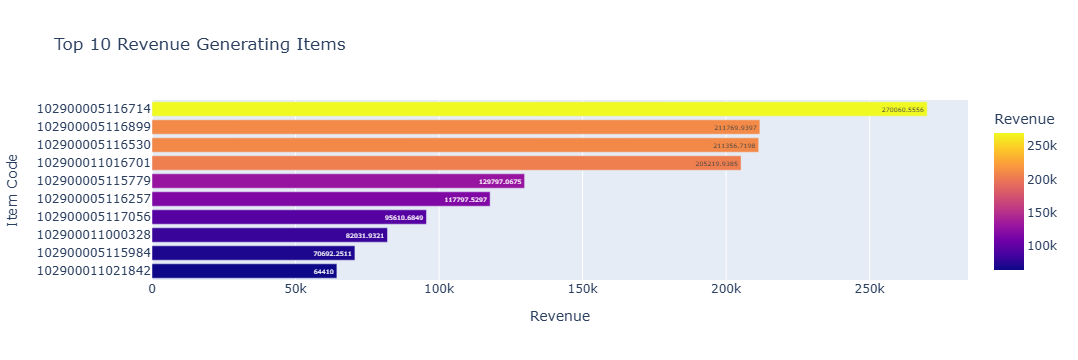

In [17]:
top_items = sales_df.groupby('Item Code')['Revenue'].sum().sort_values(ascending=False).head(10).reset_index()
top_items['Item Code'] = top_items['Item Code'].astype(str) # Convert to string for categorical plotting

fig = px.bar(top_items, x='Revenue', y='Item Code', orientation='h', 
             title='Top 10 Revenue Generating Items',
             text='Revenue', color='Revenue')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

## 4. Strategic Insights & Business Recommendations

### 📊 Visual Intelligence
- **Trend Analysis**: Use the slider in Chart 3.1. Are there dips on specific days? This could indicate stockouts or external factors (weather).
- **Peak Operations**: Chart 3.2 (Heatmap) tells you exactly when to schedule your best staff. If Friday 6 PM is red, that's your 'Power Hour'.

### 🚀 Actionable Recommendations
1.  **Workforce Optimization**:
    -   *Observation*: Look at the Heatmap. Are morning hours (9-11 AM) busier than afternoons?
    -   *Recommendation*: Shift part-time schedules to overlap with the high-intensity blocks shown in the heatmap to reduce queue times.

2.  **Inventory Planning**:
    -   *Observation*: The Top 10 items likely contribute a disproportionate amount of revenue (Pareto Principle).
    -   *Recommendation*: Implement a "Never Out of Stock" (NOOS) policy for these specific 10 Item Codes. A stockout in these items is 10x more damaging than a niche item.

3.  **Promotional Timing**:
    -   *Observation*: Identify the 'Cold Zones' in the heatmap (light blue areas).
    -   *Recommendation*: Launch "Happy Hour" flash sales during these specific low-traffic windows to flatten the demand curve.